In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!git clone https://github.com/stressGC/Food-Boundary-Box-Detection-Dataset.git

fatal: destination path 'Food-Boundary-Box-Detection-Dataset' already exists and is not an empty directory.


Load Data

In [4]:
!mkdir road_signs
!mkdir road_signs/images_resized
!mkdir road_signs/road_signs_test
!mv Food-Boundary-Box-Detection-Dataset/images ./road_signs
!mv Food-Boundary-Box-Detection-Dataset/annotations ./road_signs

mkdir: cannot create directory ‘road_signs’: File exists
mkdir: cannot create directory ‘road_signs/images_resized’: File exists
mkdir: cannot create directory ‘road_signs/road_signs_test’: File exists
mv: cannot stat 'Food-Boundary-Box-Detection-Dataset/images': No such file or directory
mv: cannot stat 'Food-Boundary-Box-Detection-Dataset/annotations': No such file or directory


In [5]:
images_path = Path('./road_signs/images')
anno_path = Path('./road_signs/annotations')

In [6]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [7]:
df_train = generate_train_df(anno_path)

In [8]:
#label encode target
class_dict = {'fries': 0, 'omelette': 1, 'rice': 2, 'icecream': 3, 'apple_pie': 4, 'burger': 5, 'hotdog': 6, 'beer': 7, 'bolonese_pasta': 8, 'bread': 9, 'carbonara': '10', 'carbonara_pasta': 11, 'chantilly': 12, 'coffee': 13,'cream': 14, 'fires': 15, 'ketchup': 16, 'pie': 17, 'potatoes': 18, 'salad': 19, 'sandwich': 20}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [9]:
print(df_train.shape)
df_train.head()

(1874, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,road_signs/images/resized_1518.jpg,250,250,1,109,28,232,154
1,road_signs/images/resized_1448.jpg,250,250,0,2,30,236,238
2,road_signs/images/resized_1549.jpg,250,250,4,17,5,209,243
3,road_signs/images/resized_710.jpg,250,250,5,1,11,179,133
4,road_signs/images/resized_1604.jpg,250,250,2,49,87,235,191


Resizing image and bounding boxes

In [10]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [11]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [12]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [13]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./road_signs/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

Sample Images

In [14]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(250, 250, 3)


In [15]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 20.,  57., 177., 212.], dtype=float32)

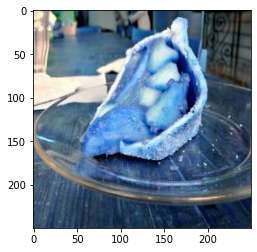

In [16]:
plt.imshow(im)

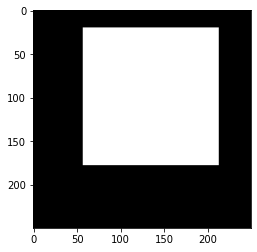

In [17]:
plt.imshow(Y, cmap='gray')

Data Augmentation

In [18]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [19]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [20]:
def create_corner_rect(bb, color='red'):
    print(bb)
    bb = np.array(bb, dtype=np.float32)
    print(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

Sample Image

[ 85.  31. 274. 434.]
[ 85.  31. 274. 434.]


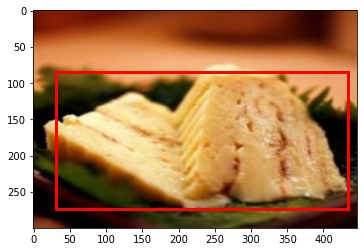

In [21]:
#original
im = cv2.imread(str(df_train.values[68][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[68][9])

[ 57.   5. 281. 422.]
[ 57.   5. 281. 422.]


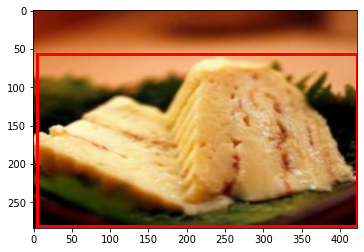

In [22]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]),df_train.values[68][9],True )
show_corner_bb(im, bb)

Train-Valid Split

In [23]:
df_train = df_train.reset_index()

In [24]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Dataset

In [26]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [27]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = int(self.y[idx])
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [28]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [29]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

Model

In [30]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 21))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

Training

In [31]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    val_losses=[]
    train_losses=[]

    for i in range(epochs):
        print('Epoch {}/{}'.format(i + 1, epochs))
        print('-' * 10)

        model.train()
        total = 0
        sum_loss = 0
        for idx, batch in enumerate(train_dl):
            x = batch[0]
            y_class = batch[1]
            y_bb = batch[2]
            batch = y_class.shape[0]
            x = x.to(device).float()
            y_class = y_class.to(device)
            y_bb = y_bb.to(device).float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        train_losses.append(train_loss)
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if (len(val_losses) > 0) and (val_loss < min(val_losses)):
            torch.save(model.state_dict(), "model_parameter.pt")
            print("At epoch {}, save model with lowest validation loss: {}".format(i, val_loss))
        val_losses.append(val_loss)
    return train_losses, val_losses

In [33]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for idx, batch in enumerate(valid_dl):
        x = batch[0]
        y_class = batch[1]
        y_bb = batch[2]
        batch = y_class.shape[0]
        x = x.to(device).float()
        y_class = y_class.to(device)
        y_bb = y_bb.to(device).float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [34]:
model = BB_model().to(device)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [35]:
epochs =15
train_losses, v_losses = train_epocs(model, optimizer, train_dl, valid_dl, epochs)

Epoch 1/15
----------
train_loss 3.972 val_loss 2834.323 val_acc 0.120
Epoch 2/15
----------
train_loss 3.284 val_loss 3.043 val_acc 0.243
At epoch 1, save model with lowest validation loss: 3.043341349283854
Epoch 3/15
----------
train_loss 2.852 val_loss 2809.017 val_acc 0.096
Epoch 4/15
----------
train_loss 2.771 val_loss 2.673 val_acc 0.232
At epoch 3, save model with lowest validation loss: 2.6730885823567707
Epoch 5/15
----------
train_loss 2.570 val_loss 12.116 val_acc 0.195
Epoch 6/15
----------
train_loss 2.448 val_loss 2.345 val_acc 0.219
At epoch 5, save model with lowest validation loss: 2.345411783854167
Epoch 7/15
----------
train_loss 2.471 val_loss 2.682 val_acc 0.213
Epoch 8/15
----------
train_loss 2.417 val_loss 3.970 val_acc 0.285
Epoch 9/15
----------
train_loss 2.566 val_loss 30.555 val_acc 0.211
Epoch 10/15
----------
train_loss 2.429 val_loss 2.426 val_acc 0.253
Epoch 11/15
----------
train_loss 2.371 val_loss 5.647 val_acc 0.264
Epoch 12/15
----------
train_lo

In [36]:
def plot_loss_graph(epoch, training_losses, validation_losses, init_folder):
    epoch_list = np.arange(1, epoch + 1)
    plt.xticks(epoch_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(epoch_list, training_losses, label = "Training loss")
    plt.plot(epoch_list, validation_losses, label = "Validation loss")
    plt.legend(loc = "upper right")
    path = str(init_folder) + "/loss.png"
    plt.savefig(path)
    plt.show()

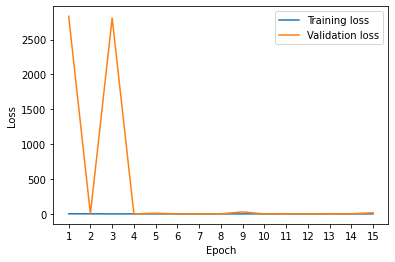

<All keys matched successfully>

In [37]:
# update_optimizer(optimizer, 0.001)
# train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)
init_folder = './results'
plot_loss_graph(epochs, train_losses, v_losses, init_folder)
model.load_state_dict(torch.load("model_parameter.pt"))

Make Prediction

In [38]:
# choose random image from validation set
X_val

,new_path,new_bb
1831,road_signs/images_resized/resized_488.jpg,"[165.0, 31.0, 261.0, 359.0]"
1198,road_signs/images_resized/resized_1586.jpg,"[22.0, 13.0, 145.0, 304.0]"
1461,road_signs/images_resized/resized_1656.jpg,"[25.0, 8.0, 290.0, 434.0]"
275,road_signs/images_resized/resized_1415.jpg,"[3.0, 8.0, 198.0, 200.0]"
416,road_signs/images_resized/resized_1030.jpg,"[68.0, 51.0, 250.0, 309.0]"
...,...,...
1165,road_signs/images_resized/resized_48.jpg,"[44.0, 38.0, 117.0, 161.0]"
374,road_signs/images_resized/resized_841.jpg,"[33.0, 46.0, 294.0, 422.0]"
271,road_signs/images_resized/resized_590.jpg,"[35.0, 12.0, 274.0, 418.0]"
184,road_signs/images_resized/resized_138.jpg,"[34.0, 74.0, 132.0, 175.0]"


In [39]:
# resizing test image
im = read_image('./road_signs/images_resized/resized_48.jpg')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('./road_signs/road_signs_test/resized_48.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [40]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./road_signs/road_signs_test/resized_48.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':0}])['y'])
x, y_class, y_bb = test_ds[0]

In [41]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [42]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[-0.4267,  2.0170,  2.4938,  2.8079,  0.6906,  1.0608,  0.5377, -4.3787,
          -2.0251,  1.5254,  1.2475, -4.3454, -2.1720, -3.8459, -4.1176, -3.5864,
          -2.6215, -4.5956, -5.1947,  1.1253, -4.6681]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[ 44.2143,  46.2117, 251.8343, 380.4942]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [43]:
# predicted class
torch.max(out_class, 1)
print(list(class_dict.keys())[list(class_dict.values()).index(torch.argmax(out_class))])

icecream


[ 44  46 251 380]
[ 44.  46. 251. 380.]


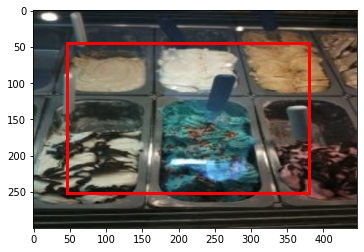

In [44]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [45]:
def create_corner_rect1(bb,img,label, color='red'):
    print(bb)
    bb = np.array(bb, dtype=np.float32)
    print(bb)
    print(label)
    _ = cv2.rectangle(img, (bb[1], bb[0]), (bb[3], bb[2]), (255,0,0), 2)
    cv2.putText(img, str(label), (int(bb[1]), int(bb[0])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.imwrite('./'+init_folder+'/predicted.png',img)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb1(im,label, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect1(bb,im, label))

[ 44  46 251 380]
[ 44.  46. 251. 380.]
icecream


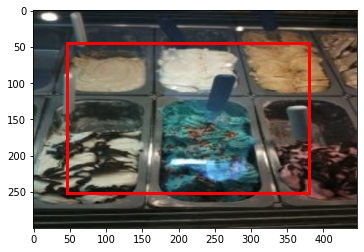

In [46]:
label = list(class_dict.keys())[list(class_dict.values()).index(torch.argmax(out_class))]
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb1(im, label,bb_hat[0])